### Escopo para cálculo de parâmetros da aba Maturação 

In [20]:
# Input de dados de pirólise (leitura de planilha .csv)
# Agrupamento de dados (cluster)
# Cálculo de COTa
# Cálculo de IHa = 100 x (S2/(COTa))
# Calculo de Tr sem vitrinita: (IHa - IH)/ IHa
# Cálculo de Ro a partir de Tmax: Ro calculada = (0,0180 x Tmax) - 7,16
# Classificação do querogênio
# Cálculo de Tr por Ro e tipo de querogênio
# Normalização dos valores de Tr na curva log (ln)
# Cálculo de TOC0, S20 e IH0
# Gráficos
# Comparação entre os resultados de Tr (Ro x IH)  

##### Dependências

In [21]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

##### Customização dos gráficos

In [22]:
# keys = plt.rcParams.keys()
# print(keys)

custom_style = {
    'figure.figsize': (8, 6),
    'axes.facecolor': 'lightgray',
    'figure.facecolor':'silver',
    'lines.linewidth': 2,
    'scatter.marker': 'o',
    'font.sans-serif': "Arial",
    'font.size': 10.5,
    'axes.grid': True,
}

##### Input de dados de pirólise (leitura de planilha .csv)

In [23]:
df = pd.read_csv("1-BAS-60-BAS.csv")
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO
0,1314.0,1.43,0.16,0.99,1.99,422.0,NaN,69.23,139.16
1,1332.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1350.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1368.0,1.03,0.12,2.66,1.86,430.0,NaN,258.25,180.58
4,1386.0,1.37,0.13,3.00,2.24,430.0,NaN,218.98,163.50
5,1404.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1422.0,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1440.0,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1458.0,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1494.0,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Agrupamento por parâmetros de pirólise

/home/rodrigo/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


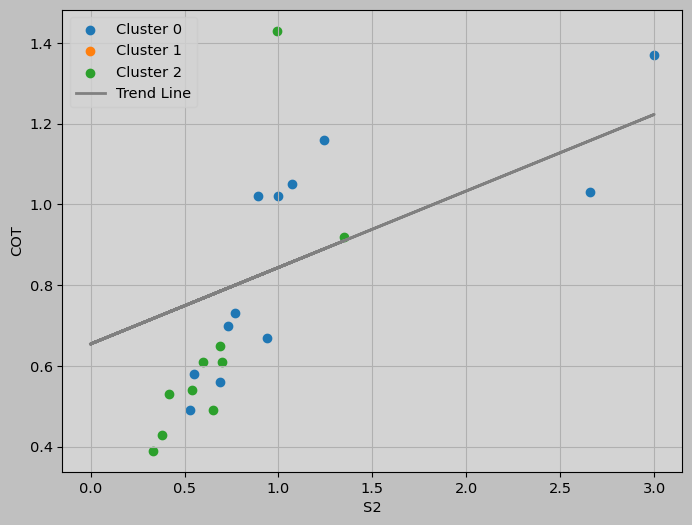

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster
0,1314.0,1.43,0.16,0.99,1.99,422.0,NaN,69.23,139.16,2
1,1332.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1350.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1368.0,1.03,0.12,2.66,1.86,430.0,NaN,258.25,180.58,0
4,1386.0,1.37,0.13,3.00,2.24,430.0,NaN,218.98,163.50,0
5,1404.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,1422.0,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,1440.0,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,1458.0,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9,1494.0,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [24]:
# Number of clusters you want to create
num_clusters = 3

# Extract the columns for clustering
X = df[["COT", "S1","S2","S3", "Tmax"]].fillna(value=0)

# Optional: Scale the data (if needed)
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Apply k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)  # Use X_scaled if you scaled the data, otherwise use X

# Get cluster assignments and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Add cluster labels to the original data frame
df['Cluster'] = cluster_labels

# Scatter plot
plt.figure(figsize=(8, 6))

# Plot data points for each cluster
for cluster_id in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_id]
    plt.scatter(cluster_data["S2"], cluster_data["COT"], label=f'Cluster {cluster_id}')

# Extract data from DataFrame
x_data = df['S2'].fillna(value=0).values.reshape(-1, 1)
y_data = df['COT'].values

# Fit linear regression model
model = LinearRegression()
model.fit(x_data, y_data)

# Get the slope (coefficient) and y-intercept of the trend line
slope = model.coef_[0]
intercept = model.intercept_


# Plot the trend line
plt.plot(x_data, model.predict(x_data), color='gray', label='Trend Line')

plt.xlabel("S2")
plt.ylabel("COT")
plt.title('')
plt.legend()
plt.grid(True)
plt.style.use(custom_style)
plt.show()
df

##### Equação de regressão linear para cada cluster

In [25]:
models = {}

for cluster_id in range(num_clusters):
    cluster_data = df[df['Cluster'] == cluster_id]
    x_values = cluster_data[["S2"]].fillna(value=0)
    y_values = cluster_data["COT"]
    model = LinearRegression()
    model.fit(x_values, y_values)
    models[cluster_id] = model

# Print the linear regression equations for each cluster
for cluster_id, model in models.items():
    slope = model.coef_[0]
    intercept = model.intercept_
    print(f"Cluster {cluster_id} - y = {slope:.2f} * x + {intercept:.2f}")

Cluster 0 - y = 0.26 * x + 0.56
Cluster 1 - y = 0.00 * x + 0.70
Cluster 2 - y = 0.75 * x + 0.16


##### Cálculo de COT ativo utilizando regressão linear

In [26]:
COTa = df["COT"]-intercept

In [27]:
#Filtro para Valores de COTa < 0
COT_cor=[]
for i in COTa:
    if i >= 0:
        COT_cor.append(i)
    else:
        COT_cor.append(0)
df["COTa"]= COT_cor
df
    
        

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa
0,1314.0,1.43,0.16,0.99,1.99,422.0,NaN,69.23,139.16,2,1.266648
1,1332.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.466648
2,1350.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.696648
3,1368.0,1.03,0.12,2.66,1.86,430.0,NaN,258.25,180.58,0,0.866648
4,1386.0,1.37,0.13,3.00,2.24,430.0,NaN,218.98,163.50,0,1.206648
5,1404.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.616648
6,1422.0,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.606648
7,1440.0,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.476648
8,1458.0,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.326648
9,1494.0,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.536648


##### Cálculo de IH0ativo
* IHa = 100 x (S2/(COTa))

In [28]:
IHa = 100*(df["S2"]/df["COTa"])
IHa_cor=[]
for i in IHa:
    if i<0:
        IHa_cor.append(0)
    elif i>=0 or i<=999:
        IHa_cor.append(i)
    else:
        IHa_cor.append("")
df["IHa"]= IHa_cor
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IHa
0,1314.0,1.43,0.16,0.99,1.99,422.0,NaN,69.23,139.16,2,1.266648,78.159044
1,1332.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.466648,
2,1350.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.696648,
3,1368.0,1.03,0.12,2.66,1.86,430.0,NaN,258.25,180.58,0,0.866648,306.929672
4,1386.0,1.37,0.13,3.00,2.24,430.0,NaN,218.98,163.50,0,1.206648,248.622621
5,1404.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.616648,
6,1422.0,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.606648,
7,1440.0,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.476648,
8,1458.0,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.326648,
9,1494.0,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.536648,


##### Calculo da Taxa de Transformação sem Ro (IH)
* (IHa - IH)/ IHa

In [29]:
df["Taxa de Transformação (IH)"] = ((df["IHa"]-df["IH"])/df["IHa"])
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IHa,Taxa de Transformação (IH)
0,1314.0,1.43,0.16,0.99,1.99,422.0,NaN,69.23,139.16,2,1.266648,78.159044,0.114242
1,1332.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.466648,,NaN
2,1350.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.696648,,NaN
3,1368.0,1.03,0.12,2.66,1.86,430.0,NaN,258.25,180.58,0,0.866648,306.929672,0.158602
4,1386.0,1.37,0.13,3.00,2.24,430.0,NaN,218.98,163.50,0,1.206648,248.622621,0.119227
5,1404.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.616648,,NaN
6,1422.0,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.606648,,NaN
7,1440.0,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.476648,,NaN
8,1458.0,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.326648,,NaN
9,1494.0,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.536648,,NaN


##### Cálculo de Ro a partir de Tmax
* Ro calculada = (0,0180 x Tmax) - 7,16

In [30]:
df["Ro (calculada)"] = (0.0180*df["Tmax"])-7.16
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IHa,Taxa de Transformação (IH),Ro (calculada)
0,1314.0,1.43,0.16,0.99,1.99,422.0,NaN,69.23,139.16,2,1.266648,78.159044,0.114242,0.436
1,1332.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.466648,,NaN,NaN
2,1350.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.696648,,NaN,NaN
3,1368.0,1.03,0.12,2.66,1.86,430.0,NaN,258.25,180.58,0,0.866648,306.929672,0.158602,0.580
4,1386.0,1.37,0.13,3.00,2.24,430.0,NaN,218.98,163.50,0,1.206648,248.622621,0.119227,0.580
5,1404.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.616648,,NaN,NaN
6,1422.0,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.606648,,NaN,NaN
7,1440.0,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.476648,,NaN,NaN
8,1458.0,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.326648,,NaN,NaN
9,1494.0,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.536648,,NaN,NaN


#### Classificação do querogênio
* Tipo I: {IH > 600} ___ {S1/S3 > 15}
* Tipo II: {IH > 300 and IH <= 600} ___ {S1/S3 > 10 and S1/S3 <15}
* Tipo II/III: {IH > 200 and IH <=300} ___ {S1/S3 > 5 and S1/S3 < 10]
* Tipo III: {IH > 50 and IH <= 200} ___ {S1/S3 > 1 and S1/S3 < 5}
* Tipo IV: {IH <= 50} ___ {S1/S3 > 1}

In [31]:

K = []
for i in df["IH"]:
    if i > 600:
        a="Tipo I"
    elif i > 300 and i <=600:
        a="Tipo II"
    elif i > 200 and i <= 300:
        a="Tipo II/III"
    elif i > 50 and i <= 200:
        a="Tipo III"
    elif i>0 and i<=50:
        a="Tipo IV"
    else:
        a=""
    K.append(a)
querogênio=pd.DataFrame(K)
df["Querogênio"]=querogênio
df


,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IHa,Taxa de Transformação (IH),Ro (calculada),Querogênio
0,1314.0,1.43,0.16,0.99,1.99,422.0,NaN,69.23,139.16,2,1.266648,78.159044,0.114242,0.436,Tipo III
1,1332.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.466648,,NaN,NaN,
2,1350.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.696648,,NaN,NaN,
3,1368.0,1.03,0.12,2.66,1.86,430.0,NaN,258.25,180.58,0,0.866648,306.929672,0.158602,0.580,Tipo II/III
4,1386.0,1.37,0.13,3.00,2.24,430.0,NaN,218.98,163.50,0,1.206648,248.622621,0.119227,0.580,Tipo II/III
5,1404.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.616648,,NaN,NaN,
6,1422.0,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.606648,,NaN,NaN,
7,1440.0,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.476648,,NaN,NaN,
8,1458.0,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.326648,,NaN,NaN,
9,1494.0,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.536648,,NaN,NaN,


#### Cálculo de Tr por Ro e tipo de querogênio
* Tipo_I = -34.430609 + (183.63837 * Ro) - (361.494 * Ro**2) + (309.9 * Ro**3) - (96.8 * Ro**4)
* Tipo_II = -822.70308 + (6217.2684 * Ro) - (19265.314 * Ro**2) + (31326.872 * Ro**3) - (28204.703 * Ro**4) + (13345.477 * Ro**5) - (2595.9299 * Ro**6)
* Tipo_III = 6.6516023 - (33.879196 * Ro) + (64.978399 * Ro**2) - (60.264818 * Ro**3) + (29.700408 * Ro**4) - (7.5019085 * Ro**5) + (0.7656397 * Ro**6)


In [32]:
# Decisão sobre Tipo de Querogênio

Ro = df["Ro (calculada)"].mean()
Eq_I = -34.430609 + (183.63837 * Ro) - (361.494 * Ro**2) + (309.9 * Ro**3) - (96.8 * Ro**4)
Eq_II = -822.70308 + (6217.2684 * Ro) - (19265.314 * Ro**2) + (31326.872 * Ro**3) - (28204.703 * Ro**4) + (13345.477 * Ro**5) - (2595.9299 * Ro**6)
Eq_III = 6.6516023 - (33.879196 * Ro) + (64.978399 * Ro**2) - (60.264818 * Ro**3) + (29.700408 * Ro**4) - (7.5019085 * Ro**5) + (0.7656397 * Ro**6)

TRo=[]
for i in df["IH"]:
    if i > 600:
        Tr_Ro = Eq_I
    elif i > 400 and i <=600:
        Tr_Ro = Eq_II
    elif i > 50 and i < 400:
        Tr_Ro = Eq_III
    else:
        Tr_Ro = 1
    TRo.append(Tr_Ro)
if Tr_Ro > 1:
    TRo.append(1)
elif Tr_Ro < 0:
    TRo.append("")
else:
    TRo.append(Tr_Ro)
TrRo=pd.DataFrame(TRo)
df["Taxa de Transformação (Ro)"]=TrRo
df


,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IHa,Taxa de Transformação (IH),Ro (calculada),Querogênio,Taxa de Transformação (Ro)
0,1314.0,1.43,0.16,0.99,1.99,422.0,NaN,69.23,139.16,2,1.266648,78.159044,0.114242,0.436,Tipo III,0.011816
1,1332.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.466648,,NaN,NaN,,1.000000
2,1350.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.696648,,NaN,NaN,,1.000000
3,1368.0,1.03,0.12,2.66,1.86,430.0,NaN,258.25,180.58,0,0.866648,306.929672,0.158602,0.580,Tipo II/III,0.011816
4,1386.0,1.37,0.13,3.00,2.24,430.0,NaN,218.98,163.50,0,1.206648,248.622621,0.119227,0.580,Tipo II/III,0.011816
5,1404.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.616648,,NaN,NaN,,1.000000
6,1422.0,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.606648,,NaN,NaN,,1.000000
7,1440.0,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.476648,,NaN,NaN,,1.000000
8,1458.0,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.326648,,NaN,NaN,,1.000000
9,1494.0,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.536648,,NaN,NaN,,1.000000


##### Filtro para valores de Tr

In [33]:
def filter_tr_ih_values(row):
    try:
        if row['Taxa de Transformação (IH)'] > 1:
            row = 1
        if row['Taxa de Transformação (IH)'] < 0:
            row = 0
        else:
            row = row['Taxa de Transformação (IH)']
        return row
    except:
        row = 1
        return row
def filter_tr_Ro_values(row):
    try:
        if row['Taxa de Transformação (Ro)'] > 1:
            row = 1
        if row['Taxa de Transformação (Ro)'] < 0:
            row = 0
        else:
            row = row['Taxa de Transformação (Ro)']
        return row
    except:
        row = 1
        return row
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IHa,Taxa de Transformação (IH),Ro (calculada),Querogênio,Taxa de Transformação (Ro)
0,1314.0,1.43,0.16,0.99,1.99,422.0,NaN,69.23,139.16,2,1.266648,78.159044,0.114242,0.436,Tipo III,0.011816
1,1332.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.466648,,NaN,NaN,,1.000000
2,1350.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.696648,,NaN,NaN,,1.000000
3,1368.0,1.03,0.12,2.66,1.86,430.0,NaN,258.25,180.58,0,0.866648,306.929672,0.158602,0.580,Tipo II/III,0.011816
4,1386.0,1.37,0.13,3.00,2.24,430.0,NaN,218.98,163.50,0,1.206648,248.622621,0.119227,0.580,Tipo II/III,0.011816
5,1404.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.616648,,NaN,NaN,,1.000000
6,1422.0,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.606648,,NaN,NaN,,1.000000
7,1440.0,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.476648,,NaN,NaN,,1.000000
8,1458.0,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.326648,,NaN,NaN,,1.000000
9,1494.0,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.536648,,NaN,NaN,,1.000000


#### Normalização dos valores de Tr na curva log (ln)

In [34]:
L = 120#float(input("Lâmina d'água: "))


MRo = df["Taxa de Transformação (Ro)"].median()
MIH = df["Taxa de Transformação (IH)"].median()

    # 4. Ajustar uma curva logaritmica com a profundidade da lamina dagua e a profundidade final e o tr na lamina dagua (zero) e o tr na profundidade final (mediana ou mínimo), utilizando scipy curve_fit

# Cálculo para valores de Ro calculada
x1 = [L, df["Profundidade"].max()]
y1 = [0, MRo]

log_fit = scipy.optimize.curve_fit(lambda t, a1, b1: a1 + b1 * np.log(t), x1, y1)
a1 = log_fit[0][0]
b1 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_Ro_Log'] = a1 + b1 * np.log(df["Profundidade"])

#================================================#

# Cálculo para valores de IH
x2 = [L, df["Profundidade"].max()]
y2 = [0, MIH]

log_fit = scipy.optimize.curve_fit(lambda t, a2, b2: a2 + b2 * np.log(t), x2, y2)
a2 = log_fit[0][0]
b2 = log_fit[0][1]

    # 5. Calcular o tr em todas as amostras do poço com a equaçao Tr = a + b * ln(profundidade)
df['Tr_IH_Log'] = a2 + b2 * np.log(df["Profundidade"])
df

    # Extra: aplicando novamente filtro para que tr seja 0 abaixo da lamina d'agua


/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/rodrigo/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,COTa,IHa,Taxa de Transformação (IH),Ro (calculada),Querogênio,Taxa de Transformação (Ro),Tr_Ro_Log,Tr_IH_Log
0,1314.0,1.43,0.16,0.99,1.99,422.0,NaN,69.23,139.16,2,1.266648,78.159044,0.114242,0.436,Tipo III,0.011816,0.756076,0.187181
1,1332.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.466648,,NaN,NaN,,1.000000,0.760374,0.188245
2,1350.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.696648,,NaN,NaN,,1.000000,0.764615,0.189295
3,1368.0,1.03,0.12,2.66,1.86,430.0,NaN,258.25,180.58,0,0.866648,306.929672,0.158602,0.580,Tipo II/III,0.011816,0.768799,0.190331
4,1386.0,1.37,0.13,3.00,2.24,430.0,NaN,218.98,163.50,0,1.206648,248.622621,0.119227,0.580,Tipo II/III,0.011816,0.772928,0.191353
5,1404.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.616648,,NaN,NaN,,1.000000,0.777005,0.192363
6,1422.0,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.606648,,NaN,NaN,,1.000000,0.781029,0.193359
7,1440.0,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.476648,,NaN,NaN,,1.000000,0.785003,0.194343
8,1458.0,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.326648,,NaN,NaN,,1.000000,0.788927,0.195314
9,1494.0,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.536648,,NaN,NaN,,1.000000,0.796633,0.197222


##### Cálculo de TOC0, S20 e IH0
* S20 = S2 / (1 - Tr)
* COT0 = COTr + ((S2 x tr)/(1 - Tr))x0,086
* IH0 = S20/COT0

In [35]:
Tr = df["Taxa de Transformação (IH)"]
df["S20"]=df["S2"]/(1-Tr)
df["COT0"]=df["COT"]+((df["S2"]*Tr)/(1-Tr))*0.086
df["IH0"]=100*df["S20"]/df["COT0"]
df

,Profundidade,COT,S1,S2,S3,Tmax,Ro,IH,IO,Cluster,...,IHa,Taxa de Transformação (IH),Ro (calculada),Querogênio,Taxa de Transformação (Ro),Tr_Ro_Log,Tr_IH_Log,S20,COT0,IH0
0,1314.0,1.43,0.16,0.99,1.99,422.0,NaN,69.23,139.16,2,...,78.159044,0.114242,0.436,Tipo III,0.011816,0.756076,0.187181,1.117687,1.440981,77.564291
1,1332.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,,NaN,NaN,,1.000000,0.760374,0.188245,NaN,NaN,NaN
2,1350.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,,NaN,NaN,,1.000000,0.764615,0.189295,NaN,NaN,NaN
3,1368.0,1.03,0.12,2.66,1.86,430.0,NaN,258.25,180.58,0,...,306.929672,0.158602,0.580,Tipo II/III,0.011816,0.768799,0.190331,3.161405,1.073121,294.599188
4,1386.0,1.37,0.13,3.00,2.24,430.0,NaN,218.98,163.50,0,...,248.622621,0.119227,0.580,Tipo II/III,0.011816,0.772928,0.191353,3.4061,1.404925,242.440079
5,1404.0,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,,NaN,NaN,,1.000000,0.777005,0.192363,NaN,NaN,NaN
6,1422.0,0.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,,NaN,NaN,,1.000000,0.781029,0.193359,NaN,NaN,NaN
7,1440.0,0.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,,NaN,NaN,,1.000000,0.785003,0.194343,NaN,NaN,NaN
8,1458.0,0.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,,NaN,NaN,,1.000000,0.788927,0.195314,NaN,NaN,NaN
9,1494.0,0.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,...,,NaN,NaN,,1.000000,0.796633,0.197222,NaN,NaN,NaN


##### Gráficos

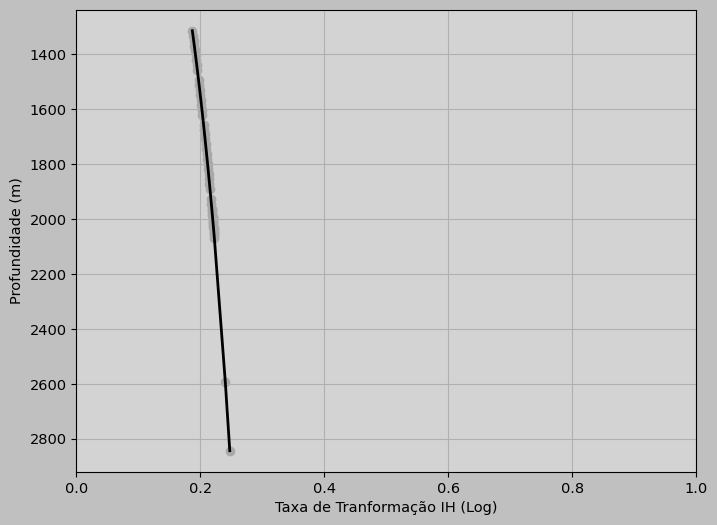

In [36]:
# Taxa de Transformação
plt.scatter(df["Tr_IH_Log"], df["Profundidade"], color="darkgrey")
plt.plot(df["Tr_IH_Log"].dropna().values, df["Profundidade"].dropna().values, color="black")
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.xlabel("Taxa de Tranformação IH (Log)")
plt.ylabel("Profundidade (m)")
plt.style.use(custom_style)
plt.show()

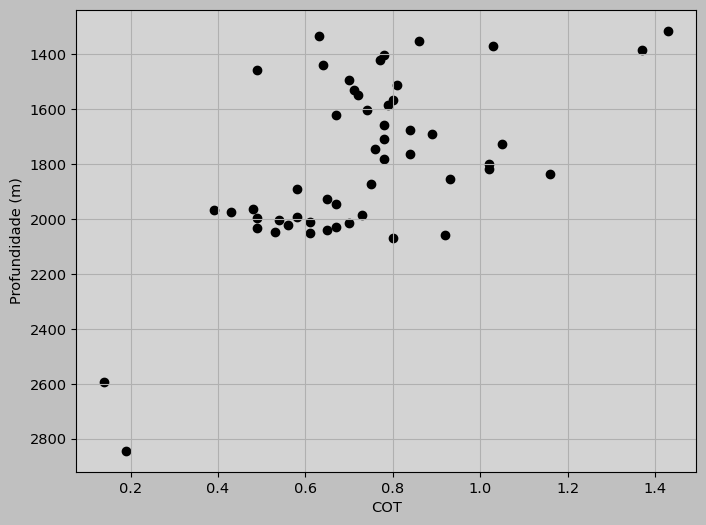

In [37]:
X=str(input("Parâmetro:"))
col = df[X]
plt.scatter(col, df["Profundidade"], color="black")
plt.gca().invert_yaxis()
plt.xlabel(X)
plt.ylabel("Profundidade (m)")
plt.style.use(custom_style)
plt.show()
